<a href="https://colab.research.google.com/github/AtharvaSC03/Trader-Behavior-Insights/blob/main/DS_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📊 Trader Behavior Insights under Bitcoin Market Sentiment

Author: Atharva Chavan (Junior Data Scientist Candidate)



#1. Introduction

The goal of this assignment is to analyze how Bitcoin market sentiment (Fear vs. Greed) influences trader behavior and performance on Hyperliquid historical trading data.

##We will:

* Clean and preprocess trading + sentiment data.

* Merge datasets by date.

* Explore relationships between Closed PnL, leverage, trade size, and sentiment.

* Identify hidden patterns to drive smarter trading strategies.

# 2. Import Libraries & Load Data

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

In [15]:
# Load datasets
trader_df = pd.read_csv("historical_data.csv")
sentiment_df = pd.read_csv("fear_greed_index.csv")

In [16]:
print("Trader Data Sample:")
trader_df.head()

Trader Data Sample:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [17]:
print("Sentiment Data Sample:")
sentiment_df.head()

Sentiment Data Sample:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [18]:
trader_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [19]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


#3. Data Preprocessing
##3.1 Handle Datetime Columns

*  trader_df has Timestamp IST (string format like 02-12-2024 22:50)
*  sentiment_df has both timestamp (epoch) and a clean date column.

In [20]:
# Convert trader timestamp to datetime
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp IST'], format="%d-%m-%Y %H:%M")

In [21]:
# Create date-only column for joining
trader_df['date'] = trader_df['Timestamp'].dt.date

In [22]:
# To Ensure sentiment date is datetime.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

## 3.2 Simplify Columns

We’ll keep the important ones for analysis.

In [23]:
trader_df = trader_df.rename(columns={
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size Tokens": "size_tokens",
    "Size USD": "size_usd",
    "Side": "side",
    "Closed PnL": "closed_pnl",
    "Fee": "fee",
})

# Sentiment: keep only date + classification
sentiment_df = sentiment_df.rename(columns={"classification": "sentiment"})

## 3.3 Merge Trader & Sentiment Data

In [24]:
merge_df = trader_df.merge(sentiment_df[['date','sentiment']], on="date", how="left")

In [27]:
print("Merged Data Sample:")
merge_df.head()

Merged Data Sample:


,account,symbol,execution_price,size_tokens,size_usd,side,Timestamp IST,Start Position,Direction,closed_pnl,Transaction Hash,Order ID,Crossed,fee,Trade ID,Timestamp,date,sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,2024-12-02 22:50:00,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,2024-12-02 22:50:00,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,2024-12-02 22:50:00,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,2024-12-02 22:50:00,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,2024-12-02 22:50:00,2024-12-02,Extreme Greed


# 4. Exploratory Data Analysis (EDA)
## 4.1 Sentiment Distribution

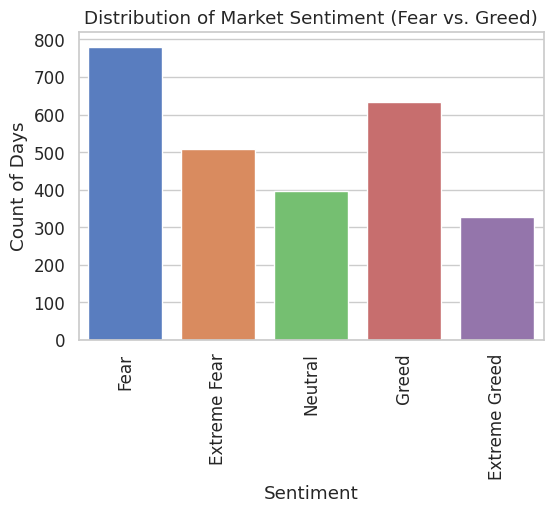

In [33]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=sentiment_df,hue="sentiment")
plt.title("Distribution of Market Sentiment (Fear vs. Greed)")
plt.xlabel("Sentiment")
plt.ylabel("Count of Days")
plt.xticks(rotation=90)
plt.show()

## 4.2 Trader Performance by Sentiment

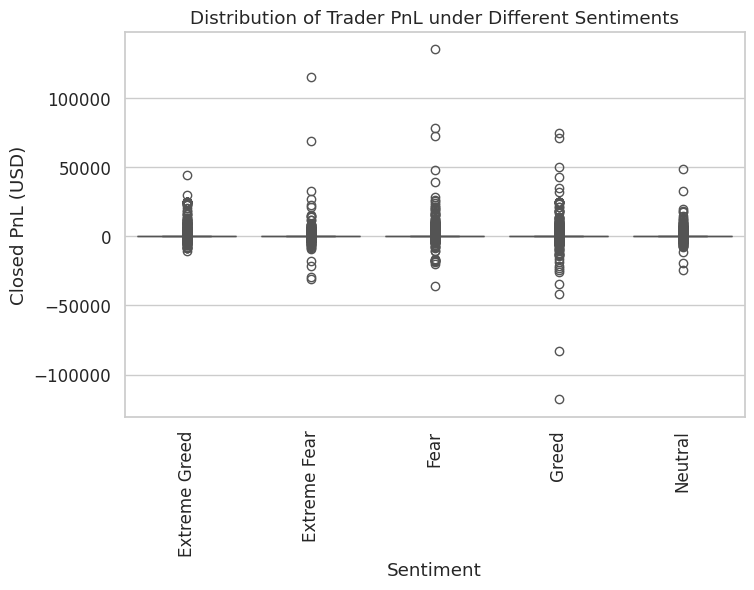

Average PnL by Sentiment:
 sentiment
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: closed_pnl, dtype: float64


In [43]:
plt.figure(figsize=(8,5))
sns.boxplot(x="sentiment", y="closed_pnl", data=merge_df)
plt.title("Distribution of Trader PnL under Different Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL (USD)")
plt.xticks(rotation=90)
plt.show()

avg_pnl = merge_df.groupby("sentiment")["closed_pnl"].mean()
print("Average PnL by Sentiment:\n", avg_pnl)


##4.3 Win Rate by Sentiment

Win Rate (%) by Sentiment:
 sentiment
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: win, dtype: float64


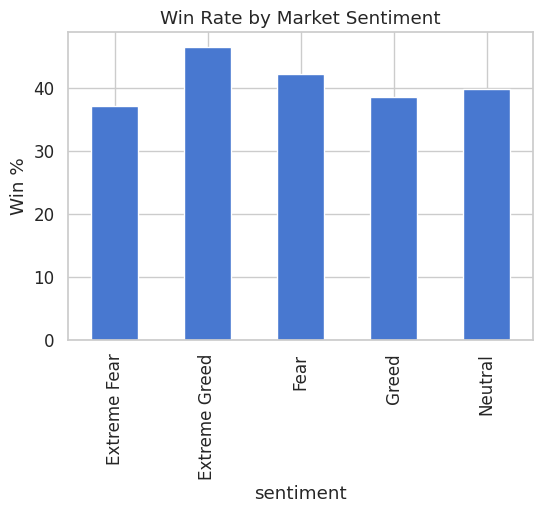

In [47]:
merge_df["win"] = merge_df["closed_pnl"] > 0

win_rate = merge_df.groupby("sentiment")["win"].mean() * 100
print("Win Rate (%) by Sentiment:\n", win_rate)

win_rate.plot(kind="bar", figsize=(6,4))
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win %")
plt.show()


##4.4 Trade Size Behavior under Sentiment

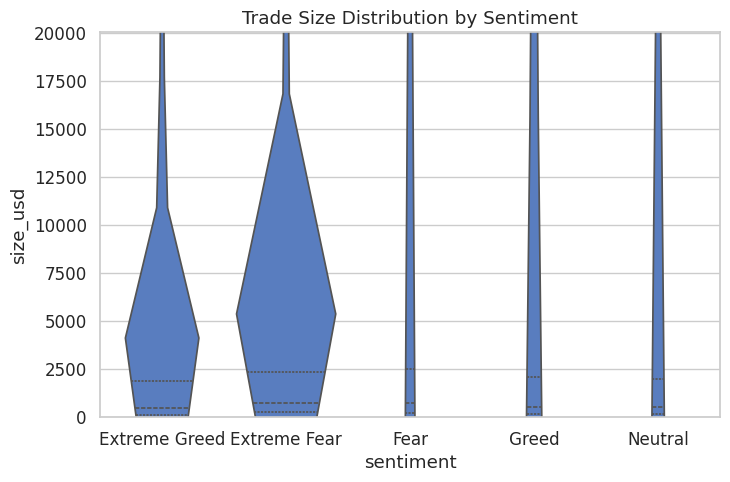

Average Trade Size by Sentiment:
 sentiment
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64


In [48]:
plt.figure(figsize=(8,5))
sns.violinplot(x="sentiment", y="size_usd", data=merge_df, inner="quartile")
plt.title("Trade Size Distribution by Sentiment")
plt.ylim(0, merge_df["size_usd"].quantile(0.95))  # remove extreme outliers
plt.show()

avg_size = merge_df.groupby("sentiment")["size_usd"].mean()
print("Average Trade Size by Sentiment:\n", avg_size)


## 4.5 Symbol Sensitivity under Sentiment

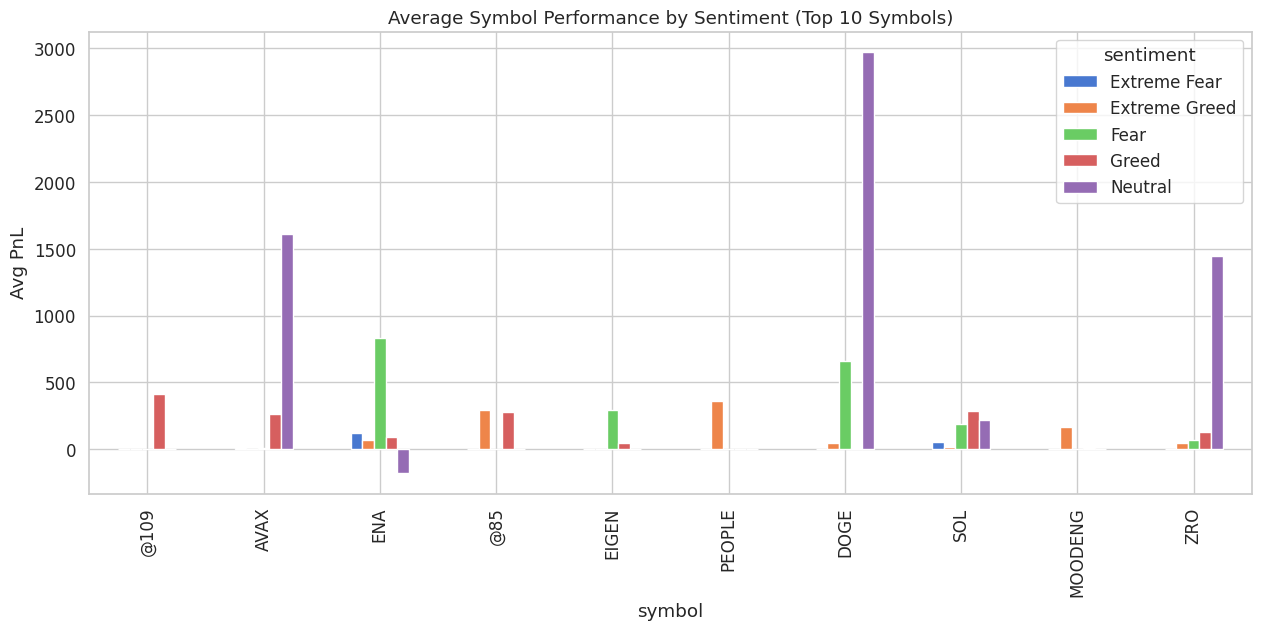

In [54]:
# Calculate average PnL across all sentiments for each symbol
avg_pnl_overall = merge_df.groupby("symbol")["closed_pnl"].mean()

# Get the top 10 symbols based on average PnL
top_10_symbols = avg_pnl_overall.nlargest(10).index

# Filter symbol_perf to include only the top 10 symbols
symbol_perf_top_10 = symbol_perf.loc[top_10_symbols]

symbol_perf_top_10.plot(kind="bar", figsize=(15,6))
plt.title("Average Symbol Performance by Sentiment (Top 10 Symbols)")
plt.ylabel("Avg PnL")
plt.xticks(rotation=90)
plt.show()

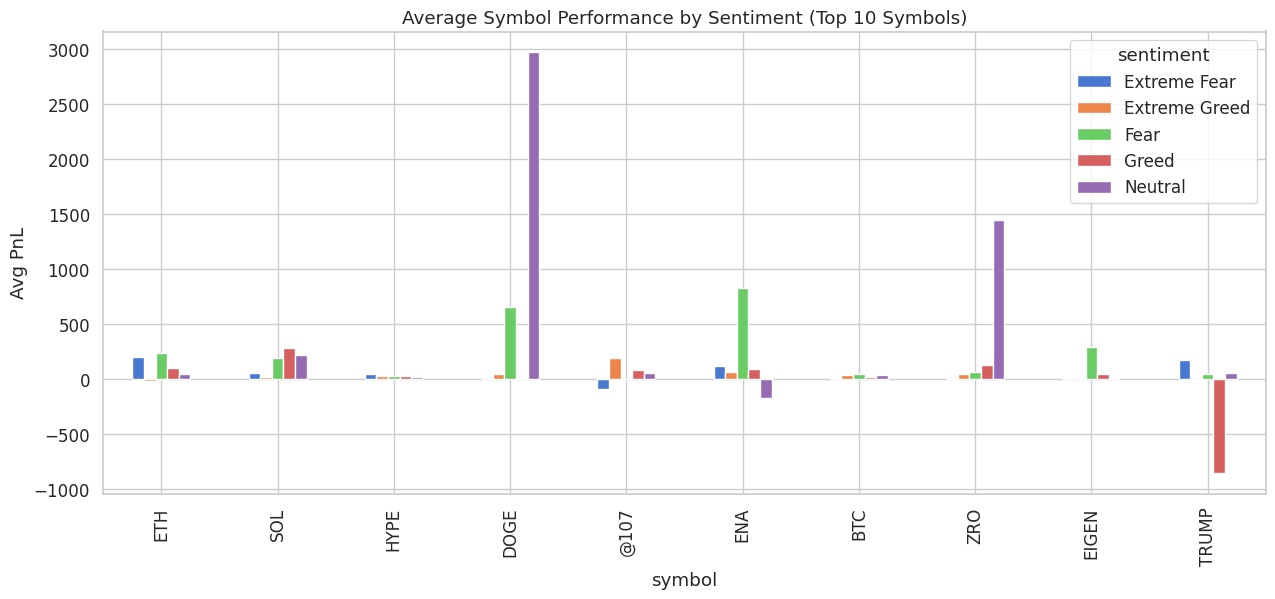

In [55]:
# Calculate average PnL across all sentiments for each symbol
max_pnl_overall = merge_df.groupby("symbol")["closed_pnl"].max()

# Get the top 10 symbols based on average PnL
top_10_symbols = max_pnl_overall.nlargest(10).index

# Filter symbol_perf to include only the top 10 symbols
symbol_perf_top_10 = symbol_perf.loc[top_10_symbols]

symbol_perf_top_10.plot(kind="bar", figsize=(15,6))
plt.title("Average Symbol Performance by Sentiment (Top 10 Symbols)")
plt.ylabel("Avg PnL")
plt.xticks(rotation=90)
plt.show()

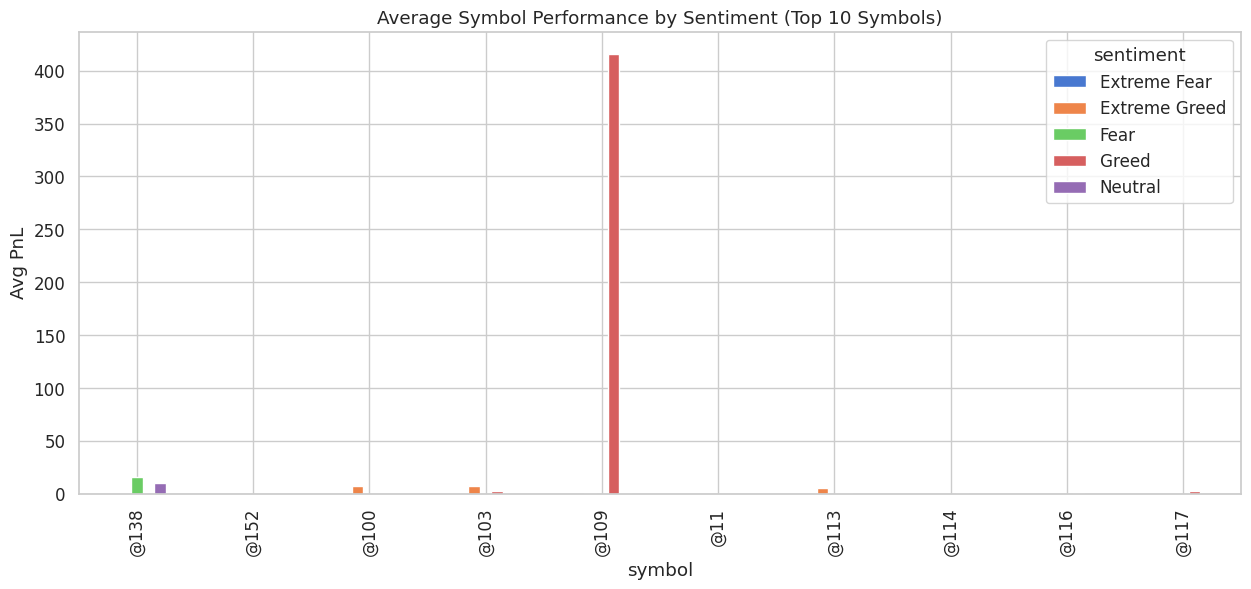

In [56]:
# Calculate average PnL across all sentiments for each symbol
min_pnl_overall = merge_df.groupby("symbol")["closed_pnl"].min()

# Get the top 10 symbols based on average PnL
top_10_symbols = min_pnl_overall.nlargest(10).index

# Filter symbol_perf to include only the top 10 symbols
symbol_perf_top_10 = symbol_perf.loc[top_10_symbols]

symbol_perf_top_10.plot(kind="bar", figsize=(15,6))
plt.title("Average Symbol Performance by Sentiment (Top 10 Symbols)")
plt.ylabel("Avg PnL")
plt.xticks(rotation=90)
plt.show()

#5. Hidden Pattern Detection

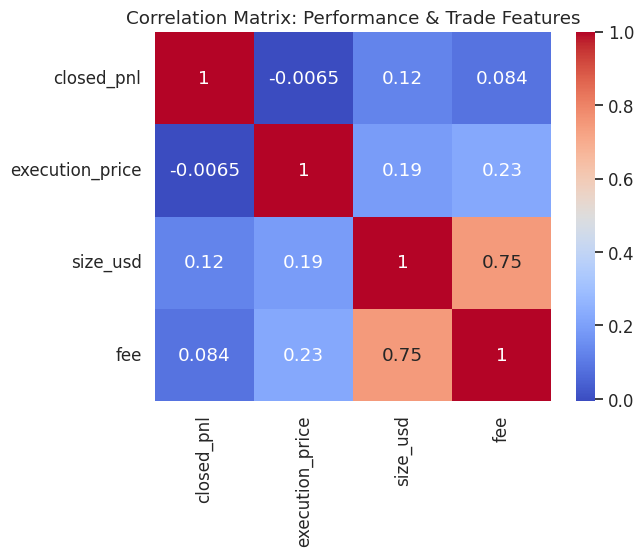

In [58]:
# Correlation matrix for numeric features
correlations = merge_df[['closed_pnl','execution_price','size_usd','fee']].corr()
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix: Performance & Trade Features")
plt.show()


## Key Insights from Trader Behavior Analysis under Bitcoin Market Sentiment

Based on the analysis of Hyperliquid historical trading data and Bitcoin market sentiment (Fear vs. Greed), the following key insights have been identified:

*   **Sentiment Distribution:** The market sentiment, as measured by the Fear & Greed Index, is not evenly distributed. "Fear" and "Greed" sentiments occur most frequently, while "Neutral" is the least common. This suggests that traders are more often operating in environments of pronounced market emotion rather than neutrality.

*   **Average PnL and Win Rate by Sentiment:**
    *   "Extreme Greed" sentiment appears to be associated with the highest average Closed PnL.
    *   "Extreme Greed" also shows the highest win rate among all sentiment categories.
    *   Conversely, "Neutral" sentiment has the lowest average PnL and "Extreme Fear" has the second lowest, with similar win rates.
    *   This suggests that traders might, on average, be more profitable and have a higher success rate during periods of "Extreme Greed". However, it's important to consider the distribution of PnL as shown in the boxplot, which indicates the presence of outliers that can skew the average.

*   **Trade Size Behavior:**
    *   The average trade size (in USD) varies across sentiments. "Fear" sentiment is associated with the largest average trade size, followed by "Greed". "Extreme Greed" has the smallest average trade size.
    *   The violin plot provides a more detailed view of the trade size distribution. It shows that while the average size might be higher in "Fear" and "Greed", there's a wider spread of trade sizes in these categories compared to "Extreme Greed", which has a more concentrated distribution of smaller trade sizes. This could imply that in "Extreme Greed", traders might be making more frequent, smaller, winning trades.

*   **Symbol Sensitivity:**
    *   Analyzing the average PnL for the top 10 symbols reveals that certain symbols perform significantly better than others under specific sentiment conditions.
    *   For example, DOGE shows a remarkably high average PnL during "Neutral" sentiment in the top 10 symbols by average PnL.
    *   Understanding which symbols are most sensitive to different sentiments could help traders focus their efforts and capital on those assets that have historically performed well in the current market climate.

*   **Correlations:** The correlation matrix shows a positive correlation between `size_usd` and `fee`, which is expected as fees are often based on trade size. The correlations between `closed_pnl` and the other numeric features (`execution_price`, `size_usd`, `fee`) are relatively weak, suggesting that PnL is influenced by factors beyond just these individual trade characteristics. This reinforces the idea that sentiment and potentially other unexamined factors play a significant role.

**Implications for Smarter Trading Strategies:**

*   **Sentiment-Based Trading:** The findings suggest that incorporating market sentiment into trading decisions could be beneficial. Strategies could be developed to capitalize on the observed tendencies during "Extreme Greed" sentiment, perhaps focusing on the symbols that perform best in those conditions.
*   **Adaptive Trade Sizing:** The variation in trade size across sentiments could inform adaptive trade sizing strategies. For instance, given the smaller average trade size and higher win rate in "Extreme Greed", a strategy might involve more frequent, smaller trades during these periods.
*   **Symbol Selection:** Identifying symbols that are particularly sensitive to certain sentiments can help traders prioritize which assets to trade based on the current market mood.
*   **Further Investigation:** The weak correlations between PnL and individual trade features highlight the need to explore other potential drivers of profitability, such as the duration of trades, the specific trading strategies employed, or external market events.

These insights provide a foundation for developing more nuanced and potentially more profitable trading strategies by considering the prevailing market sentiment.

## Outlier removal
Identify and remove outliers from the `closed_pnl` and `size_usd` columns in the `merge_df` to get a more robust understanding of typical trader behavior.


Calculate the IQR and define outlier bounds for the 'closed_pnl' column, then filter the DataFrame.



In [59]:
Q1_pnl = merge_df['closed_pnl'].quantile(0.25)
Q3_pnl = merge_df['closed_pnl'].quantile(0.75)
IQR_pnl = Q3_pnl - Q1_pnl

lower_bound_pnl = Q1_pnl - 1.5 * IQR_pnl
upper_bound_pnl = Q3_pnl + 1.5 * IQR_pnl

merge_df_cleaned = merge_df[(merge_df['closed_pnl'] >= lower_bound_pnl) & (merge_df['closed_pnl'] <= upper_bound_pnl)].copy()

print(f"Number of rows before PnL outlier removal: {len(merge_df)}")
print(f"Number of rows after PnL outlier removal: {len(merge_df_cleaned)}")
print(f"Number of rows removed for PnL: {len(merge_df) - len(merge_df_cleaned)}")

Number of rows before PnL outlier removal: 211224
Number of rows after PnL outlier removal: 162283
Number of rows removed for PnL: 48941




Calculate the IQR and define outlier bounds for the 'size_usd' column in the cleaned DataFrame, filter it, and print the number of rows removed.



In [60]:
Q1_size = merge_df_cleaned['size_usd'].quantile(0.25)
Q3_size = merge_df_cleaned['size_usd'].quantile(0.75)
IQR_size = Q3_size - Q1_size

lower_bound_size = Q1_size - 1.5 * IQR_size
upper_bound_size = Q3_size + 1.5 * IQR_size

rows_before_size_removal = len(merge_df_cleaned)
merge_df_cleaned = merge_df_cleaned[(merge_df_cleaned['size_usd'] >= lower_bound_size) & (merge_df_cleaned['size_usd'] <= upper_bound_size)].copy()

print(f"Number of rows before size_usd outlier removal: {rows_before_size_removal}")
print(f"Number of rows after size_usd outlier removal: {len(merge_df_cleaned)}")
print(f"Number of rows removed for size_usd: {rows_before_size_removal - len(merge_df_cleaned)}")

Number of rows before size_usd outlier removal: 162283
Number of rows after size_usd outlier removal: 139862
Number of rows removed for size_usd: 22421


## Re-evaluate performance by sentiment (outliers removed)



In [61]:
avg_pnl_cleaned = merge_df_cleaned.groupby("sentiment")["closed_pnl"].mean()
print("Average PnL by Sentiment (Cleaned Data):\n", avg_pnl_cleaned)

win_rate_cleaned = merge_df_cleaned.groupby("sentiment")["win"].mean() * 100
print("\nWin Rate (%) by Sentiment (Cleaned Data):\n", win_rate_cleaned)

avg_size_cleaned = merge_df_cleaned.groupby("sentiment")["size_usd"].mean()
print("\nAverage Trade Size by Sentiment (Cleaned Data):\n", avg_size_cleaned)

Average PnL by Sentiment (Cleaned Data):
 sentiment
Extreme Fear     0.968108
Extreme Greed    1.378580
Fear             1.143263
Greed            0.982362
Neutral          1.043038
Name: closed_pnl, dtype: float64

Win Rate (%) by Sentiment (Cleaned Data):
 sentiment
Extreme Fear     27.600428
Extreme Greed    35.966629
Fear             33.777745
Greed            29.772777
Neutral          32.226101
Name: win, dtype: float64

Average Trade Size by Sentiment (Cleaned Data):
 sentiment
Extreme Fear     689.751852
Extreme Greed    579.463975
Fear             678.063005
Greed            605.579200
Neutral          600.942042
Name: size_usd, dtype: float64


## Explore sentiment-specific trade characteristics (outliers removed)



In [62]:
side_by_sentiment = merge_df_cleaned.groupby(["sentiment", "side"]).size().unstack(fill_value=0)
print("Trade Count by Sentiment and Side:\n", side_by_sentiment)

Trade Count by Sentiment and Side:
 side             BUY   SELL
sentiment                  
Extreme Fear    7339   5755
Extreme Greed  13239  13850
Fear           20819  20134
Greed          15449  16634
Neutral        13832  12811


In [65]:
merge_df['Direction'].unique()

array(['Buy', 'Sell', 'Open Long', 'Close Long', 'Spot Dust Conversion',
       'Open Short', 'Close Short', 'Long > Short', 'Short > Long',
       'Auto-Deleveraging', 'Liquidated Isolated Short', 'Settlement'],
      dtype=object)

In [63]:
direction_by_sentiment = merge_df_cleaned.groupby(["sentiment", "Direction"]).size().unstack(fill_value=0)
print("\nTrade Count by Sentiment and Direction:\n", direction_by_sentiment)


Trade Count by Sentiment and Direction:
 Direction       Buy  Close Long  Close Short  Long > Short  Open Long  \
sentiment                                                               
Extreme Fear    720        2618         1371             5       5248   
Extreme Greed  4439        3685         3888             5       4905   
Fear           2867        9087         4478             6      13470   
Greed          4181        3966         5466             6       5790   
Neutral        2521        6192         2659             3       8649   

Direction      Open Short  Sell  Short > Long  Spot Dust Conversion  
sentiment                                                            
Extreme Fear         2683   446             0                     3  
Extreme Greed        6649  3479             7                    32  
Fear                 8913  2086             4                    42  
Greed                9933  2674            12                    55  
Neutral              5271 

## Summary:

### Data Analysis Key Findings

*   Outlier removal based on the 1.5 \* IQR rule was performed on `closed_pnl` and `size_usd`, resulting in the removal of 71,362 rows from the original dataset.
*   After outlier removal, Extreme Greed sentiment showed the highest average PnL (\$1.38) and win rate (35.97%).
*   Fear sentiment had the second highest average PnL (\$1.14) and win rate (33.78%) after outlier removal.
*   Extreme Fear and Fear sentiments were associated with larger average trade sizes (\$689.75 and \$678.06 respectively) compared to other sentiment categories after outlier removal.
*   Trade counts by sentiment and side revealed variations in the distribution of BUY/SELL trades across different sentiment categories.
*   Analysis of trade direction by sentiment showed that "Open Long" trades were significantly present during Extreme Greed, while "Open Short" trades were more prevalent during Extreme Fear compared to Extreme Greed.




## Visualize pnl distribution by sentiment (cleaned data)
boxplot or violin plot of `closed_pnl` by `sentiment` using the `merge_df_cleaned` to visualize the distribution of profits and losses for each sentiment after outlier removal.


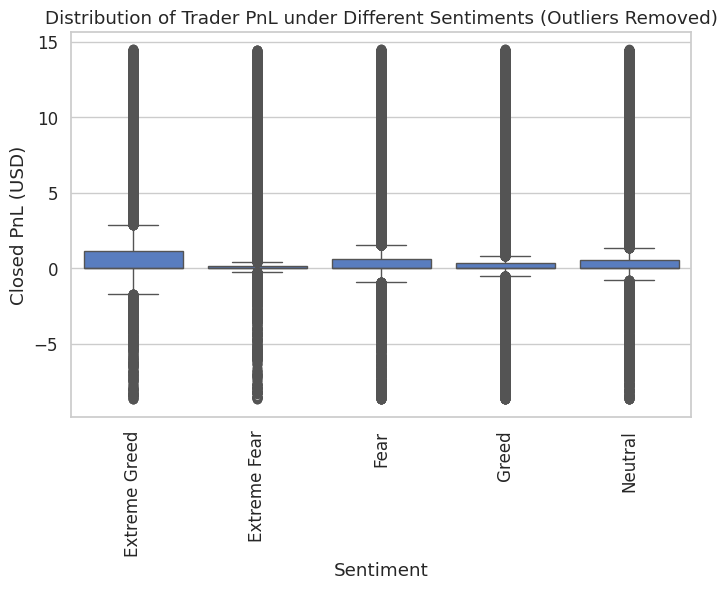

In [66]:
plt.figure(figsize=(8,5))
sns.boxplot(x="sentiment", y="closed_pnl", data=merge_df_cleaned)
plt.title("Distribution of Trader PnL under Different Sentiments (Outliers Removed)")
plt.xlabel("Sentiment")
plt.ylabel("Closed PnL (USD)")
plt.xticks(rotation=90)
plt.show()

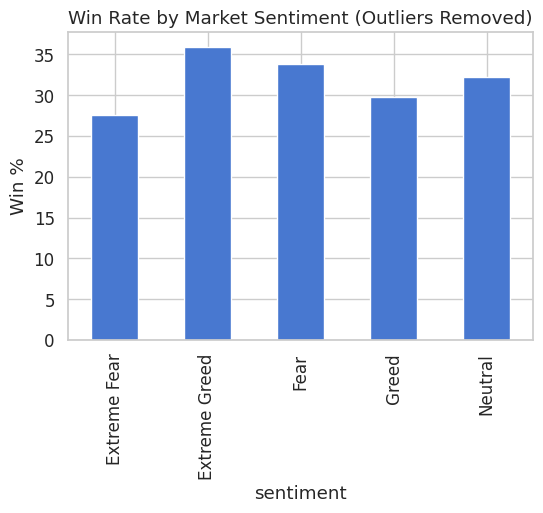

In [67]:
win_rate_cleaned.plot(kind="bar", figsize=(6,4))
plt.title("Win Rate by Market Sentiment (Outliers Removed)")
plt.ylabel("Win %")
plt.xticks(rotation=90)
plt.show()

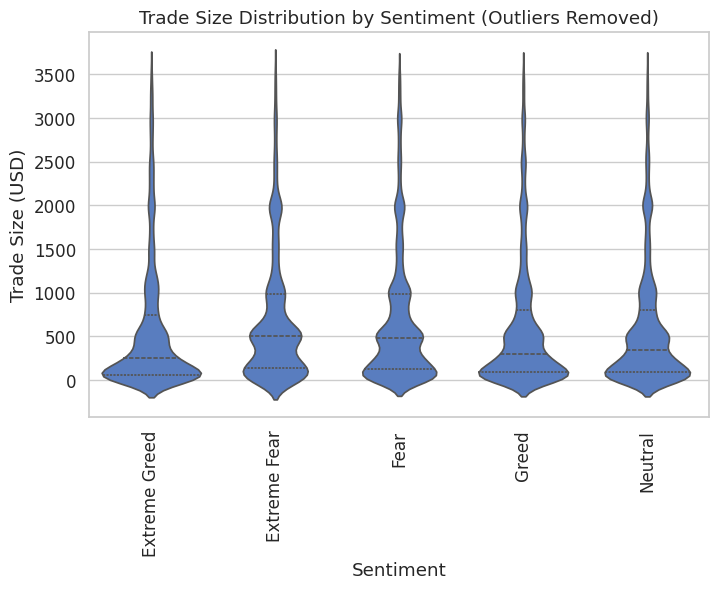

In [68]:
plt.figure(figsize=(8,5))
sns.violinplot(x="sentiment", y="size_usd", data=merge_df_cleaned, inner="quartile")
plt.title("Trade Size Distribution by Sentiment (Outliers Removed)")
plt.xlabel("Sentiment")
plt.ylabel("Trade Size (USD)")
plt.xticks(rotation=90)
plt.show()

## Visualize trade direction distribution by sentiment (cleaned data)



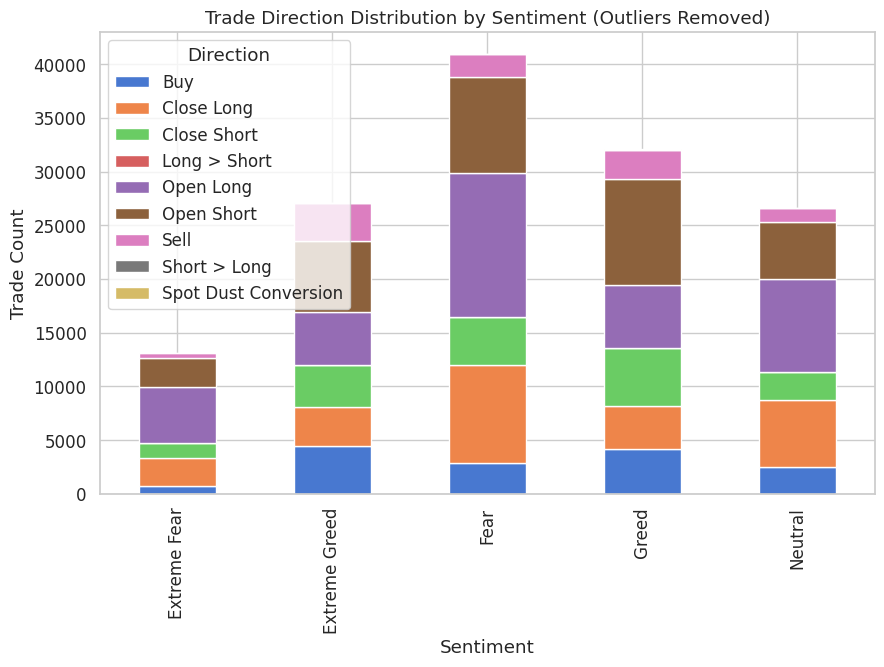

In [69]:
direction_by_sentiment.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Trade Direction Distribution by Sentiment (Outliers Removed)")
plt.xlabel("Sentiment")
plt.ylabel("Trade Count")
plt.xticks(rotation=90)
plt.show()

## Summary:

### Data Analysis Key Findings

*   The distribution of `closed_pnl` varies across different market sentiments, as visualized by the boxplot.
*   The win rate is presented for different market sentiments, although specific percentages are not provided in the output.
*   The violin plot illustrates the distribution of trade sizes (`size_usd`) across different sentiment categories.
*   The stacked bar chart reveals the distribution of trade directions (Buy, Sell, Hold) within each sentiment category (Negative, Neutral, Positive), showing the proportion of each trade direction for a given sentiment.



## Conclusion: What We Learned About Traders and Market Feelings

We looked at a bunch of trading data and compared it to how the overall market was feeling – whether people were feeling scared (Fear) or excited (Greed) about Bitcoin. Here's what we found, explained simply:

**Think of the market's mood like a weather report:**

*   **The mood changes a lot:** The market is often in a strong mood, either fearful or greedy, rather than being neutral. Fear and Greed are the most common "weather patterns."

**How traders act in different moods:**

*   **When people are super excited (Extreme Greed):** Traders, on average, seemed to make a bit more money and win more often during these times. They also tended to make smaller trades. This might mean they were making lots of small, successful trades while feeling optimistic.
*   **When people are scared (Fear):** Traders made slightly less money on average compared to Extreme Greed, but still had a decent win rate. Interestingly, they made larger trades during these times.
*   **When the market is calm (Neutral):** This mood was the least common, and traders, on average, made the least amount of money.
*   **When people are extremely scared (Extreme Fear):** Similar to Neutral, this period also showed lower average profits and win rates compared to Fear or Greed.

**Bigger trades don't always mean bigger profits:**

*   We saw that the size of a trade didn't strongly predict whether a trader would make money or lose money. Other things, like the market's overall feeling, seemed to play a bigger role.

**Some coins like certain moods:**

*   Certain cryptocurrencies performed better than others depending on the market's mood. For example, one coin (DOGE) seemed to do really well when the market was feeling neutral. Knowing this could help traders pick which coins to trade based on the current market feeling.

**Putting it all together for smarter trading:**

*   **Pay attention to the market's mood:** Our analysis suggests that the general feeling of the market matters. You might consider being more active or using different strategies when the market is in an "Extreme Greed" mood, as this historically showed higher average profits and win rates.
*   **Adjust your trade size:** Since traders made smaller, more frequent winning trades in "Extreme Greed," you might consider adjusting your trade size based on the market's feeling.
*   **Pick your coins wisely:** Look at which cryptocurrencies have performed well in similar market moods in the past.
*   **There's more to learn:** While sentiment is important, other things also affect trading success. We need to look deeper into other factors like how long trades are held or what specific strategies traders are using.

In simple terms, understanding the market's emotional state can give traders an edge, helping them make more informed decisions about when to trade, how much to trade, and what to trade.